**Handwritten Equation Solver Using CNN**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Importing Dataset File**

In [3]:
!kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset

handwritten-math-symbol-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzipping the Dataset File**

In [4]:
import zipfile
zip=zipfile.ZipFile("/content/handwritten-math-symbol-dataset.zip","r")
zip.extractall('/content')
zip.close()

**Importing Necessary Required Libraries**

In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.13.0


In [37]:
train_dir=Path("/content/train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [38]:
test_dir=Path("/content/eval")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

**Preproccessing the Images in the the Folder**

In [39]:
import pandas as pd

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [40]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)

In [41]:
print("---Trainig Set---\n")
print(f"Number of Images: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

---Trainig Set---

Number of Images: 7557

Number of different labels: 16

Labels: ['five' 'one' 'eight' 'decimal' 'zero' 'equal' 'seven' 'minus' 'three'
 'div' 'two' 'four' 'nine' 'times' 'plus cleaned' 'six']


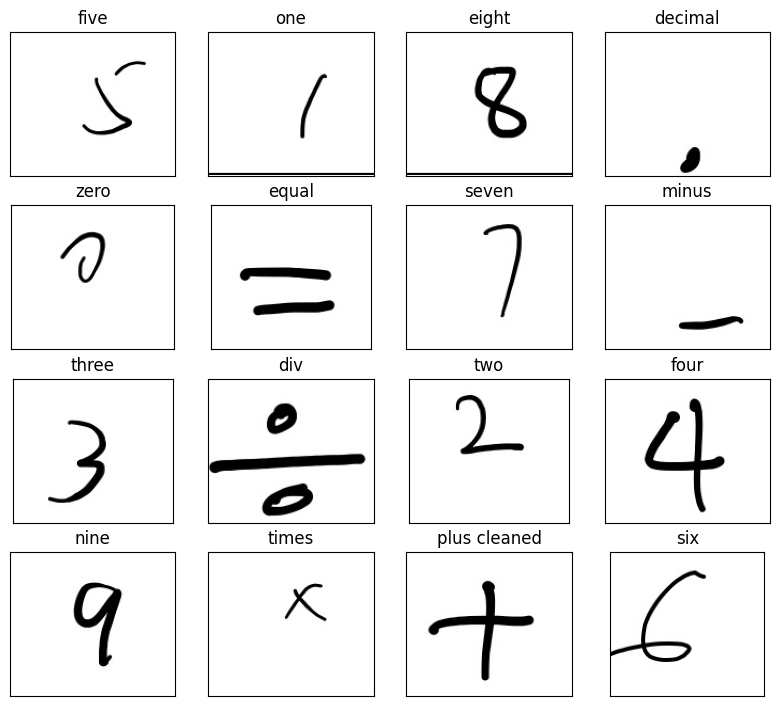

In [42]:
#Create a DataFrame with one label of each category
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Displaying Some Images of the dataset
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [43]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [44]:
#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 7557 validated image filenames belonging to 16 classes.


In [45]:
#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


Found 1010 validated image filenames belonging to 16 classes.


In [46]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

**CNN Model**

In [16]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer to avoid overfitting

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)

outputs = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
237/237 [==============================] - 23s 69ms/step - loss: 0.6382 - accuracy: 0.9055 - val_loss: 0.3475 - val_accuracy: 0.9733
Epoch 2/5
237/237 [==============================] - 15s 63ms/step - loss: 0.3034 - accuracy: 0.9743 - val_loss: 0.2928 - val_accuracy: 0.9683
Epoch 3/5
237/237 [==============================] - 16s 69ms/step - loss: 0.2379 - accuracy: 0.9766 - val_loss: 0.2102 - val_accuracy: 0.9782
Epoch 4/5
237/237 [==============================] - 15s 61ms/step - loss: 0.1893 - accuracy: 0.9839 - val_loss: 0.1862 - val_accuracy: 0.9832
Epoch 5/5
237/237 [==============================] - 14s 60ms/step - loss: 0.1657 - accuracy: 0.9836 - val_loss: 0.1613 - val_accuracy: 0.9822


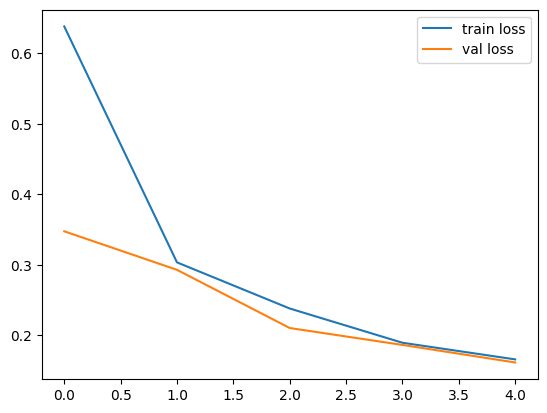

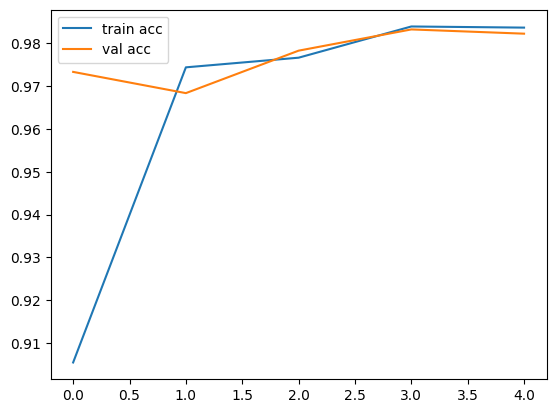

<Figure size 640x480 with 0 Axes>

In [47]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [48]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

32/32 [==============================] - 2s 49ms/step


['times',
 'decimal',
 'div',
 'three',
 'five',
 'nine',
 'plus cleaned',
 'two',
 'plus cleaned',
 'zero',
 'equal',
 'eight',
 'seven',
 'six',
 'five',
 'times',
 'zero',
 'seven',
 'equal',
 'nine',
 'times',
 'six',
 'six',
 'equal',
 'times',
 'div',
 'nine',
 'nine',
 'times',
 'three',
 'minus',
 'four',
 'five',
 'minus',
 'one',
 'minus',
 'four',
 'six',
 'plus cleaned',
 'eight',
 'three',
 'four',
 'nine',
 'plus cleaned',
 'eight',
 'three',
 'minus',
 'zero',
 'equal',
 'seven',
 'minus',
 'three',
 'decimal',
 'three',
 'plus cleaned',
 'equal',
 'times',
 'minus',
 'div',
 'decimal',
 'times',
 'equal',
 'eight',
 'plus cleaned',
 'zero',
 'one',
 'two',
 'decimal',
 'div',
 'five',
 'plus cleaned',
 'eight',
 'eight',
 'zero',
 'plus cleaned',
 'div',
 'seven',
 'equal',
 'five',
 'eight',
 'decimal',
 'two',
 'equal',
 'div',
 'nine',
 'five',
 'equal',
 'two',
 'equal',
 'six',
 'four',
 'equal',
 'seven',
 'decimal',
 'times',
 'two',
 'two',
 'minus',
 'decimal',

**Output Function to Preprocess and Predict Images Labels**

In [49]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class=answer.argmax(axis=-1)
  y=" ".join(str(x) for x in y_class)
  y=int(y)
  res=labels[y]
  return res

**Predicting Image Label**

1/1 [==============================] - 0s 22ms/step
The Predicted Digit is five.


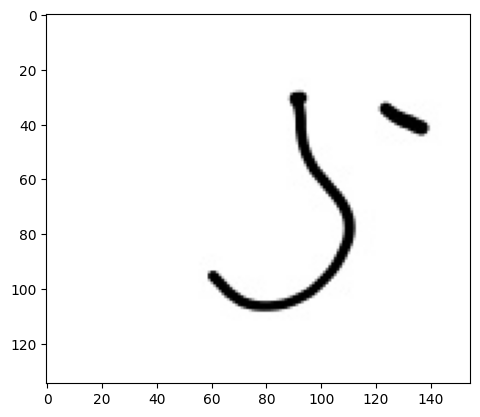

In [51]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

test_img= cv2.imread("/content/eval/five/20969.jpg")
plt.imshow(test_img)

pred=output("/content/eval/five/20969.jpg")

print(f"The Predicted Digit is {pred}.")

**Returning Integer Value To Predicted Images Labels**

In [52]:
def strToSymbol(pred):

    if pred == "zero":
        return 0
    elif pred == "one":
        return 1
    elif pred == "two":
        return 2
    elif pred == "three":
        return 3
    elif pred == "four":
        return 4
    elif pred == "five":
        return 5
    elif pred == "six":
        return 6
    elif pred == "seven":
        return 7
    elif pred == "eight":
        return 8
    elif pred == "nine":
        return 9
    elif pred == "plus":
        return '+'
    elif pred == "minus":
        return '-'
    elif pred == "div":
        return '/'
    elif pred == "equal":
        return '='
    elif pred == "decimal":
        return '.'
    elif pred == "times":
        return '*'

**Calculate Function after Predicting Images Label**

In [53]:
def calculate(par1, sym, par2):
    if sym == "plus":
        return strToSymbol(par1) + strToSymbol(par2)
    elif sym == "minus":
        return strToSymbol(par1) - strToSymbol(par2)
    elif sym == "div":
        return strToSymbol(par1) / strToSymbol(par2)
    elif sym == "decimal":
        return str(par1 + sym + par2)
    elif sym == "times":
        return strToSymbol(par1) * strToSymbol(par2)

**Predictive Sytsem to Solve Equation from Image Prediction**

1/1 [==============================] - 0s 102ms/step


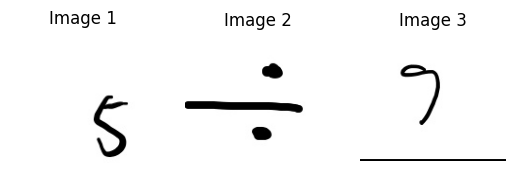

Recognized Equation: 5 / 9
Solution: 0.5555555555555556


In [56]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

# Function to predict the label for an image
def predict_label(image_path):
    # Loading the image and make a prediction
    test_img = cv2.imread(image_path)
    pred = output(image_path)  #Prediction function
    return pred

# Function to recognize labels and create an equation
def recognize_and_solve_equation(images):
    equation = []

    for img_path in images:
        label = predict_label(img_path)
        equation.append(label)

    # Converting the equation elements to their corresponding symbols
    equation = [strToSymbol(label) for label in equation]

    # Joining the equation elements to form a string
    equation_str = ' '.join(map(str, equation))

    # Evaluating the equation
    try:
        result = eval(equation_str)
        return equation_str, result
    except Exception as e:
        return equation_str, "Error: " + str(e)

# List of image paths for the equation elements
image_paths = [
    "/content/eval/five/24764.jpg",# Replace with the actual paths
    "/content/eval/div val/240.jpg",
    "/content/eval/nine/15273.jpg",
]

equation_str, result = recognize_and_solve_equation(image_paths)

# Displaying the input images
fig, axs = plt.subplots(1, len(image_paths))
for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f"Image {i + 1}")
    axs[i].axis('off')

plt.show()

print("Recognized Equation:", equation_str)
print("Solution:", result)
